In [95]:
from sklearn.datasets import make_multilabel_classification
from sklearn.neural_network import MLPClassifier
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import scale

In [117]:
def mosthighlycorrelated(mydataframe, numtoreport):
    cormatrix = mydataframe.corr()
    cormatrix *= np.tri(*cormatrix.values.shape, k=-1).T
    cormatrix = cormatrix.stack()
    cormatrix = cormatrix.reindex(cormatrix.abs().sort_values(ascending=False).index).reset_index()
    cormatrix.columns = ["FirstVariable", "SecondVariable", "Correlation"]
    print("Наилучшая корреляция:")
    print(cormatrix.head(numtoreport))
    print("Наихудшая корреляция:")
    print(cormatrix.tail(numtoreport))

In [129]:
'''
класс принимает количество компонент, которые надо оставить
или -1 и название критерия выбора компонент:
1 - Кайзера
2 - сломанной трости
3 - каменистой осыпи
fit(X) принимает набор входных объектов X и обучает модель
transform(X) преобразует X в новое векторное пространстро
'''

class my_pca():
    def __init__(self, components = -1, kr = 1):
        self.components = components
        self.kr = kr;

    def fit(self, X):
        '''
        главные компоненты - собственные векторы соответствующих 
        топ-k штук собственных значений матрицы ковариации признаков:

        ищем ковариации признаков, 
        chisla - ее собственные числа
        matr - матрица собственных значений
        упорядочиваем значения по убыванию, берем топ-k штук
        '''
        #print(1)

        X_new = X
        mosthighlycorrelated(pd.DataFrame(X), 10)
        print()
        covmat = np.cov(X_new.T)
        #print(covmat)
        sns.heatmap(covmat, vmax=1., square=False).xaxis.tick_top()
        plt.show()
        chisla, matr = np.linalg.eig(covmat)
        if chisla[0] < chisla[-1]:
            matr = matr[:,::-1]
            
        
        if self.components == -1:
            #print(2)

            # правило Кайзера - значимы те собственные числа, 
            # что больше среднего значения всех собственных чисел
            if self.kr == 1:
                #print(21)

                self.components = chisla[chisla > chisla.mean()].size
                print("Количество компонент (Кайзер): ", self.components)
                self.v = -matr[:,:self.components]
                #print(self.v)
            # правило сломанной трости
            if self.kr == 2:
                trMatr = sum(covmat[i][i] for i in range(covmat.shape[0]))
                norm_ch = chisla/trMatr
                trost = np.random.sample(chisla.shape[0])
                #3 random чисел *  1 / [сумма чисел]. Cумма будет равна 1.
                trost = trost*(1/trost.sum())
                trost = np.sort(trost)[::-1]
                self.components = chisla[chisla > trost].size
                print("Количество компонент (трость): ", self.components)
                self.v = -matr[:,:self.components]
            # правило каменистой осыпи
            if self.kr == 3:
                print(range(chisla.shape[0]))
                plt.plot(range(chisla.shape[0]), chisla)
                plt.scatter(range(chisla.shape[0]), chisla)
                plt.show()
                print("Choose N of components")
                self.components = int(input())
                print("Количество компонент (осыпь): ", self.components)
                self.v = -matr[:,:self.components]
            print(self.v)

                

        
    
    def transform(self, X):
        '''
        умножаем матрицу данных на компоненты - получаем проекцию 
        данных в ортогональном базисе этих компонент
        '''
        return(np.dot(X, self.v))

In [119]:
'''
классификация на MNIST

загружаем mnist, Х - признаки, У - классы
разбиваем данные на тренировочные и валидационные
берем неглубокое дерево решений
обучаем его и предсказываем на валидационной выборке
считаем точность - по ней будем сравнивать работу алгоритмов
'''
digits = datasets.load_digits()
X = digits.data
y = digits.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, 
                                                    stratify=y, 
                                                    random_state=42)

clf = DecisionTreeClassifier(max_depth=6, random_state=42)
clf.fit(X_train, y_train)
preds = clf.predict_proba(X_test)
print('Accuracy: {:.5f}'.format(accuracy_score(y_test, 
                                                preds.argmax(axis=1))))

Accuracy: 0.77963


Наилучшая корреляция:
   FirstVariable  SecondVariable  Correlation
0              2              58     0.937623
1              1              57     0.855610
2              3              59     0.767945
3             13              21     0.732505
4              6              14     0.730296
5              7              15     0.711073
6             54              61     0.707519
7             33              41     0.670915
8             46              54     0.664351
9             15              23     0.658243
Наихудшая корреляция:
      FirstVariable  SecondVariable  Correlation
3711             44               3         -0.0
3712             44               2         -0.0
3713             44               1         -0.0
3714             43              43          0.0
3715             43              42          0.0
3716             43              41          0.0
3717             43              40          0.0
3718             43              38         -0.0
3719     

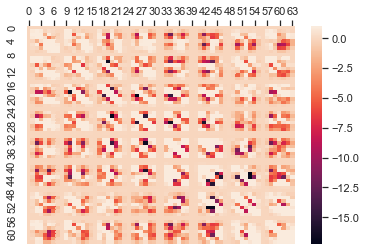

In [120]:
'''
классификация на MNIST 
загружаем mnist, Х - признаки, У - классы
проводим обработку данных
разбиваем данные на тренировочные и валидационные
берем неглубокое дерево решений
обучаем его и предсказываем на валидационной выборке
считаем точность - по ней будем сравнивать работу алгоритмов
'''
digits = datasets.load_digits()
X = digits.data
y = digits.target
X = pd.DataFrame(X)
standardisedX = scale(X)
standardisedX = pd.DataFrame(standardisedX, index=X.index, columns=X.columns)

# не задаем компоненты
pca = my_pca(-1, 1)
# нормализация
X_centered = X - X.mean(axis=0)
pca.fit(X_centered)
Xnew = pca.transform(X_centered)

X_train, X_test, y_train, y_test = train_test_split(Xnew, y, test_size=.3, 
                                                    stratify=y, 
                                                    random_state=42)

clf = DecisionTreeClassifier(max_depth=6, random_state=42)
clf.fit(X_train, y_train)
preds = clf.predict_proba(X_test)
print('Accuracy: {:.5f}'.format(accuracy_score(y_test, 
                                                preds.argmax(axis=1))))

Наилучшая корреляция:
   FirstVariable  SecondVariable  Correlation
0              2              58     0.937623
1              1              57     0.855610
2              3              59     0.767945
3             13              21     0.732505
4              6              14     0.730296
5              7              15     0.711073
6             54              61     0.707519
7             33              41     0.670915
8             46              54     0.664351
9             15              23     0.658243
Наихудшая корреляция:
      FirstVariable  SecondVariable  Correlation
3711             44               3         -0.0
3712             44               2         -0.0
3713             44               1         -0.0
3714             43              43          0.0
3715             43              42          0.0
3716             43              41          0.0
3717             43              40          0.0
3718             43              38         -0.0
3719     

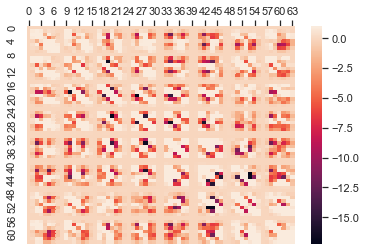

In [127]:
'''
Сломанная трость
'''
digits = datasets.load_digits()
X = digits.data
y = digits.target
X = pd.DataFrame(X)
standardisedX = scale(X)
standardisedX = pd.DataFrame(standardisedX, index=X.index, columns=X.columns)

# не задаем компоненты
pca = my_pca(-1, 2)
# нормализация
X_centered = X - X.mean(axis=0)
pca.fit(X_centered)
Xnew = pca.transform(X_centered)

X_train, X_test, y_train, y_test = train_test_split(Xnew, y, test_size=.3, 
                                                    stratify=y, 
                                                    random_state=42)

clf = DecisionTreeClassifier(max_depth=6, random_state=42)
clf.fit(X_train, y_train)
preds = clf.predict_proba(X_test)
print('Accuracy: {:.5f}'.format(accuracy_score(y_test, 
                                                preds.argmax(axis=1))))

Наилучшая корреляция:
   FirstVariable  SecondVariable  Correlation
0              2              58     0.937623
1              1              57     0.855610
2              3              59     0.767945
3             13              21     0.732505
4              6              14     0.730296
5              7              15     0.711073
6             54              61     0.707519
7             33              41     0.670915
8             46              54     0.664351
9             15              23     0.658243
Наихудшая корреляция:
      FirstVariable  SecondVariable  Correlation
3711             44               3         -0.0
3712             44               2         -0.0
3713             44               1         -0.0
3714             43              43          0.0
3715             43              42          0.0
3716             43              41          0.0
3717             43              40          0.0
3718             43              38         -0.0
3719     

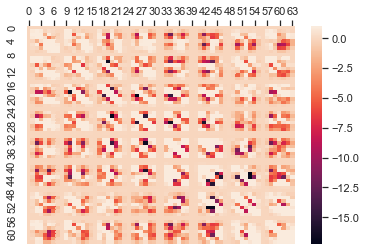

range(0, 64)


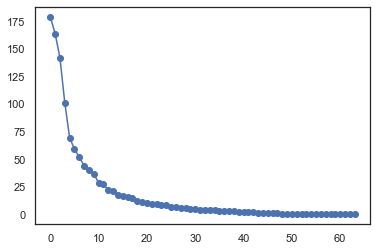

Choose N of components
9
Количество компонент (осыпь):  9
[[-0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  -0.00000000e+00]
 [-1.73094651e-02 -1.01064569e-02  1.83420720e-02 -2.00129102e-02
   1.40785917e-02  9.63005661e-03  2.48955281e-03  2.26464557e-02
  -1.69783375e-02]
 [-2.23428835e-01 -4.90849204e-02  1.26475543e-01 -1.77426961e-01
   8.28241888e-02  8.09634095e-02  3.70118913e-02  2.06952505e-01
  -9.85477578e-02]
 [-1.35913304e-01 -9.43337493e-03  1.32154802e-01 -1.95680567e-01
  -6.56023800e-02 -1.27363415e-02  2.22512417e-02  1.00480604e-01
  -4.02192330e-02]
 [-3.30323092e-02 -5.36015636e-02 -1.34016054e-01 -3.20886824e-02
  -1.53939923e-02  1.47986029e-02  1.13315073e-01 -1.22665757e-01
  -1.88268901e-01]
 [-9.66340844e-02 -1.17755318e-01 -2.64938820e-01 -9.51350604e-02
   1.66985193e-01 -3.13877963e-02  1.19675757e-01 -3.16359505e-01
  -2.06574291e-01]
 [-8.32943805e-03 -6.21281792e-02 -1

In [132]:
'''
Каменная осыпь
'''
digits = datasets.load_digits()
X = digits.data
y = digits.target
X = pd.DataFrame(X)
standardisedX = scale(X)
standardisedX = pd.DataFrame(standardisedX, index=X.index, columns=X.columns)

# не задаем компоненты
pca = my_pca(-1, 3)
# нормализация
X_centered = X - X.mean(axis=0)
pca.fit(X_centered)
Xnew = pca.transform(X_centered)

X_train, X_test, y_train, y_test = train_test_split(Xnew, y, test_size=.3, 
                                                    stratify=y, 
                                                    random_state=42)

clf = DecisionTreeClassifier(max_depth=6, random_state=42)
clf.fit(X_train, y_train)
preds = clf.predict_proba(X_test)
print('Accuracy: {:.5f}'.format(accuracy_score(y_test, 
                                                preds.argmax(axis=1))))

In [134]:
data = pd.read_csv('data/drug_consumption.csv', sep=',', header=None)
drop1 = [c for c in range(13, 18)]
drop2 = [c for c in range(19, 32)]
dropInd = drop1 + drop2
dropInd.insert(0,0)
data.drop(dropInd, axis = 1, inplace=True)

In [135]:
d =  {'CL0': 0, 'CL1': 1, 'CL2': 2, 'CL3': 3, 'CL4': 4, 'CL5': 5, 'CL6': 6}
data[13] = data[18].map(d)
data.drop([18], axis = 1, inplace=True)
data

,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084,0
1,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,4
2,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148,3
3,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084,2
4,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1880,-0.95197,0.48246,-0.61113,-0.57009,-0.31685,-1.19430,1.74091,1.88511,0.76096,-1.13788,0.88113,1.92173,5
1881,-0.95197,-0.48246,-0.61113,-0.57009,-0.31685,-0.24649,1.74091,0.58331,0.76096,-1.51840,0.88113,0.76540,3
1882,-0.07854,0.48246,0.45468,-0.57009,-0.31685,1.13281,-1.37639,-1.27553,-1.77200,-1.38502,0.52975,-0.52593,6
1883,-0.95197,0.48246,-0.61113,-0.57009,-0.31685,0.91093,-1.92173,0.29338,-1.62090,-2.57309,1.29221,1.22470,6


In [136]:
data.describe()

,1,2,3,4,5,6,7,8,9,10,11,12,13
count,1885.00000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000
mean,0.03461,-0.000256,-0.003806,0.355542,-0.309577,0.000047,-0.000163,-0.000534,-0.000245,-0.000386,0.007216,-0.003292,2.989390
std,0.87836,0.482588,0.950078,0.700335,0.166226,0.998106,0.997448,0.996229,0.997440,0.997523,0.954435,0.963701,2.287438
min,-0.95197,-0.482460,-2.435910,-0.570090,-1.107020,-3.464360,-3.273930,-3.273930,-3.464360,-3.464360,-2.555240,-2.078480,0.000000
25%,-0.95197,-0.482460,-0.611130,-0.570090,-0.316850,-0.678250,-0.695090,-0.717270,-0.606330,-0.652530,-0.711260,-0.525930,1.000000
50%,-0.07854,-0.482460,-0.059210,0.960820,-0.316850,0.042570,0.003320,-0.019280,-0.017290,-0.006650,-0.217120,0.079870,3.000000
75%,0.49788,0.482460,0.454680,0.960820,-0.316850,0.629670,0.637790,0.723300,0.760960,0.584890,0.529750,0.765400,5.000000
max,2.59171,0.482460,1.984370,0.960820,1.907250,3.273930,3.273930,2.901610,3.464360,3.464360,2.901610,1.921730,6.000000


In [137]:
data.groupby(13)[1].agg(['count'])

,count
13,
0,413
1,207
2,266
3,211
4,140
5,185
6,463


In [139]:
X = data.iloc[:,:12].values
y = data.iloc[:,12].values

In [148]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, 
                                                    stratify=y, 
                                                    random_state=42)

clf = DecisionTreeClassifier(max_depth = 6, random_state=42)
clf.fit(X_train, y_train)
preds = clf.predict_proba(X_test)
print('Accuracy: {:.5f}'.format(accuracy_score(y_test, 
                                                preds.argmax(axis=1))))

Accuracy: 0.36396


Наилучшая корреляция:
   FirstVariable  SecondVariable  Correlation
0             10              11     0.623120
1              5               6    -0.431051
2              7              11     0.421709
3              5               9    -0.391088
4              0               3     0.354241
5              3              11    -0.345415
6              3               7    -0.341969
7              9              10    -0.335133
8              0              11    -0.332188
9              6               9     0.308024
Наихудшая корреляция:
     FirstVariable  SecondVariable  Correlation
134              8               0          0.0
135              8               1          0.0
136              8               2          0.0
137              8               3          0.0
138              8               4         -0.0
139              8               5         -0.0
140              8               6          0.0
141              8               7          0.0
142              8

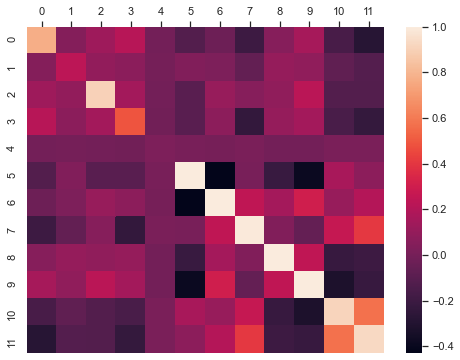

Количество компонент (Кайзер):  4
[[ 2.66525638e-01 -1.06689459e-01 -3.08194706e-01 -1.76166583e-01]
 [ 9.40733374e-02 -1.75144940e-02  7.15224692e-02 -9.55711517e-02]
 [ 2.12370963e-01  1.33947538e-01 -4.61353458e-02 -8.38578501e-01]
 [ 2.34748243e-01 -4.82495209e-02 -1.74782245e-01 -9.32700321e-02]
 [-1.24007785e-02  5.94445863e-03  4.24507435e-03 -3.90311902e-04]
 [-3.05696345e-01 -4.11286114e-01  2.69116015e-01 -3.58865066e-01]
 [ 9.42365066e-02  5.96407203e-01 -2.11750419e-01  9.81294097e-02]
 [-2.67377326e-01  4.25937052e-01  3.87802051e-01 -2.86426738e-01]
 [ 2.91228204e-01  1.91515716e-01  7.27999819e-01  1.48166813e-01]
 [ 4.15553278e-01  2.84586321e-01 -7.21293798e-02 -3.54801790e-02]
 [-4.36633828e-01  1.89780300e-01 -2.25500412e-01 -6.46609932e-02]
 [-4.44728508e-01  3.28695769e-01 -1.16259689e-01 -8.42921825e-03]]
Accuracy: 0.35689


In [149]:
'''
Кайзер
'''

X = pd.DataFrame(X)
standardisedX = scale(X)
standardisedX = pd.DataFrame(standardisedX, index=X.index, columns=X.columns)

# не задаем компоненты
pca = my_pca(-1, 1)
# нормализация
X_centered = X - X.mean(axis=0)
pca.fit(X_centered)
Xnew = pca.transform(X_centered)

X_train, X_test, y_train, y_test = train_test_split(Xnew, y, test_size=.3, 
                                                    stratify=y, 
                                                    random_state=42)

clf = DecisionTreeClassifier(max_depth=6, random_state=42)
clf.fit(X_train, y_train)
preds = clf.predict_proba(X_test)
print('Accuracy: {:.5f}'.format(accuracy_score(y_test, 
                                                preds.argmax(axis=1))))

Наилучшая корреляция:
   FirstVariable  SecondVariable  Correlation
0             10              11     0.623120
1              5               6    -0.431051
2              7              11     0.421709
3              5               9    -0.391088
4              0               3     0.354241
5              3              11    -0.345415
6              3               7    -0.341969
7              9              10    -0.335133
8              0              11    -0.332188
9              6               9     0.308024
Наихудшая корреляция:
     FirstVariable  SecondVariable  Correlation
134              8               0          0.0
135              8               1          0.0
136              8               2          0.0
137              8               3          0.0
138              8               4         -0.0
139              8               5         -0.0
140              8               6          0.0
141              8               7          0.0
142              8

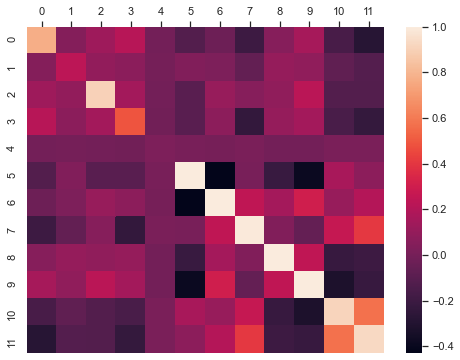

Количество компонент (трость):  11
[[ 2.66525638e-01 -1.06689459e-01 -3.08194706e-01 -1.76166583e-01
  -1.52148701e-03 -4.57675112e-01 -1.07655329e-02  2.02804783e-01
  -2.15129211e-01 -6.37921252e-01 -2.95889093e-01]
 [ 9.40733374e-02 -1.75144940e-02  7.15224692e-02 -9.55711517e-02
   1.53292645e-02 -7.98928157e-02 -9.56566979e-01  6.90418188e-02
   7.89970962e-02  1.49439536e-01 -1.03569975e-01]
 [ 2.12370963e-01  1.33947538e-01 -4.61353458e-02 -8.38578501e-01
  -2.67380178e-03  8.45139704e-03  7.67660419e-02  1.32362091e-01
  -4.85762858e-02  2.01946517e-01  3.69994482e-01]
 [ 2.34748243e-01 -4.82495209e-02 -1.74782245e-01 -9.32700321e-02
  -2.59845397e-02 -3.06075106e-01  3.81173832e-02 -8.56803166e-01
   5.06290907e-02  1.54863996e-01 -2.55814451e-02]
 [-1.24007785e-02  5.94445863e-03  4.24507435e-03 -3.90311902e-04
  -9.99466178e-01  7.71901899e-03 -1.53247738e-02  2.21334488e-02
  -6.17448531e-04  1.98427153e-04 -8.50346492e-03]
 [-3.05696345e-01 -4.11286114e-01  2.69116015e-01 

In [150]:
'''
Сломанная трость
'''

X = pd.DataFrame(X)
standardisedX = scale(X)
standardisedX = pd.DataFrame(standardisedX, index=X.index, columns=X.columns)

# не задаем компоненты
pca = my_pca(-1, 2)
# нормализация
X_centered = X - X.mean(axis=0)
pca.fit(X_centered)
Xnew = pca.transform(X_centered)

X_train, X_test, y_train, y_test = train_test_split(Xnew, y, test_size=.3, 
                                                    stratify=y, 
                                                    random_state=42)

clf = DecisionTreeClassifier(max_depth=6, random_state=42)
clf.fit(X_train, y_train)
preds = clf.predict_proba(X_test)
print('Accuracy: {:.5f}'.format(accuracy_score(y_test, 
                                                preds.argmax(axis=1))))

Наилучшая корреляция:
   FirstVariable  SecondVariable  Correlation
0             10              11     0.623120
1              5               6    -0.431051
2              7              11     0.421709
3              5               9    -0.391088
4              0               3     0.354241
5              3              11    -0.345415
6              3               7    -0.341969
7              9              10    -0.335133
8              0              11    -0.332188
9              6               9     0.308024
Наихудшая корреляция:
     FirstVariable  SecondVariable  Correlation
134              8               0          0.0
135              8               1          0.0
136              8               2          0.0
137              8               3          0.0
138              8               4         -0.0
139              8               5         -0.0
140              8               6          0.0
141              8               7          0.0
142              8

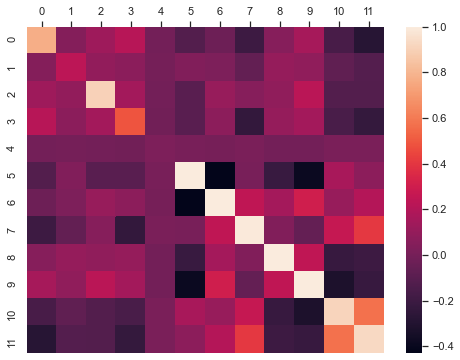

range(0, 12)


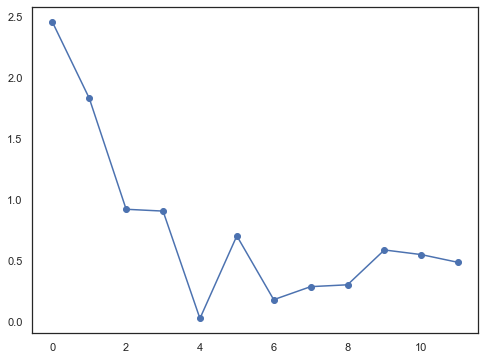

Choose N of components
6
Количество компонент (осыпь):  6
[[ 2.66525638e-01 -1.06689459e-01 -3.08194706e-01 -1.76166583e-01
  -1.52148701e-03 -4.57675112e-01]
 [ 9.40733374e-02 -1.75144940e-02  7.15224692e-02 -9.55711517e-02
   1.53292645e-02 -7.98928157e-02]
 [ 2.12370963e-01  1.33947538e-01 -4.61353458e-02 -8.38578501e-01
  -2.67380178e-03  8.45139704e-03]
 [ 2.34748243e-01 -4.82495209e-02 -1.74782245e-01 -9.32700321e-02
  -2.59845397e-02 -3.06075106e-01]
 [-1.24007785e-02  5.94445863e-03  4.24507435e-03 -3.90311902e-04
  -9.99466178e-01  7.71901899e-03]
 [-3.05696345e-01 -4.11286114e-01  2.69116015e-01 -3.58865066e-01
   5.71901383e-03 -6.90234712e-02]
 [ 9.42365066e-02  5.96407203e-01 -2.11750419e-01  9.81294097e-02
   4.17554536e-03 -1.34600356e-01]
 [-2.67377326e-01  4.25937052e-01  3.87802051e-01 -2.86426738e-01
   4.42396404e-03  2.19569027e-01]
 [ 2.91228204e-01  1.91515716e-01  7.27999819e-01  1.48166813e-01
  -3.30527127e-03 -5.08855674e-01]
 [ 4.15553278e-01  2.84586321e-01

In [151]:
'''
Каменная осыпь
'''

X = pd.DataFrame(X)
standardisedX = scale(X)
standardisedX = pd.DataFrame(standardisedX, index=X.index, columns=X.columns)

# не задаем компоненты
pca = my_pca(-1, 3)
# нормализация
X_centered = X - X.mean(axis=0)
pca.fit(X_centered)
Xnew = pca.transform(X_centered)

X_train, X_test, y_train, y_test = train_test_split(Xnew, y, test_size=.3, 
                                                    stratify=y, 
                                                    random_state=42)

clf = DecisionTreeClassifier(max_depth=6, random_state=42)
clf.fit(X_train, y_train)
preds = clf.predict_proba(X_test)
print('Accuracy: {:.5f}'.format(accuracy_score(y_test, 
                                                preds.argmax(axis=1))))

In [156]:
data = pd.read_csv('data/qsar_oral_toxicity.csv', sep=';', header=None)
data

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,negative
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,negative
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,negative
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,negative
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8987,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,negative
8988,0,1,0,0,0,1,0,1,0,0,...,0,0,0,1,0,0,0,0,0,negative
8989,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,negative
8990,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,negative


In [157]:
d =  {'negative': 0, 'positive': 1}
data[1024]= data[1024].map(d)
data

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8987,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
8988,0,1,0,0,0,1,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
8989,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
8990,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [158]:
data.describe()

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024
count,8992.000000,8992.000000,8992.000000,8992.000000,8992.000000,8992.000000,8992.000000,8992.000000,8992.000000,8992.000000,...,8992.000000,8992.000000,8992.000000,8992.00000,8992.000000,8992.000000,8992.000000,8992.000000,8992.000000,8992.000000
mean,0.212967,0.035698,0.068728,0.033363,0.018683,0.144795,0.123109,0.193728,0.013790,0.017349,...,0.061277,0.016681,0.164368,0.23899,0.022464,0.022020,0.021797,0.022353,0.018461,0.082407
std,0.409427,0.185547,0.253005,0.179593,0.135411,0.351914,0.328581,0.395240,0.116625,0.130574,...,0.239850,0.128082,0.370630,0.42649,0.148197,0.146755,0.146029,0.147838,0.134618,0.274998
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [159]:
data.groupby(1024)[1].agg(['count'])

,count
1024,
0,8251
1,741


In [160]:
X = data.iloc[:,:1024].values
y = data.iloc[:,1024].values

In [162]:
y

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [163]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, 
                                                    stratify=y, 
                                                    random_state=42)

clf = DecisionTreeClassifier(max_depth = 6, random_state=42)
clf.fit(X_train, y_train)
preds = clf.predict_proba(X_test)
print('Accuracy: {:.5f}'.format(accuracy_score(y_test, 
                                                preds.argmax(axis=1))))

Accuracy: 0.92291


Наилучшая корреляция:
   FirstVariable  SecondVariable  Correlation
0            414             759     0.981486
1            685             871     0.975301
2            260             683     0.972504
3            758             871     0.971219
4            456             819     0.970810
5            288             960     0.970227
6            646             758     0.969676
7            178             405     0.969388
8            116             408     0.967029
9            349             424     0.964966
Наихудшая корреляция:
         FirstVariable  SecondVariable  Correlation
1048566            685             220          0.0
1048567            685             219          0.0
1048568            685             218          0.0
1048569            685             217         -0.0
1048570            685             216          0.0
1048571            685             215         -0.0
1048572            685             214          0.0
1048573            685            

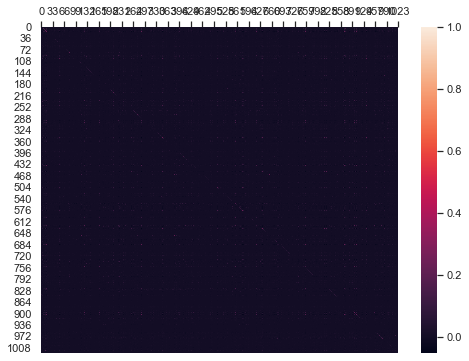

Количество компонент (Кайзер):  170
[[-0.05950275 -0.02614212 -0.08273083 ... -0.02286864  0.02112354
  -0.02082397]
 [ 0.00481585 -0.02007328  0.0001882  ...  0.0199917   0.01979142
   0.0600169 ]
 [ 0.01012645  0.00879499 -0.0081833  ... -0.00218232 -0.05369212
   0.02385749]
 ...
 [ 0.00115576 -0.00667854 -0.0031236  ... -0.015967    0.00313049
   0.00063887]
 [-0.00463942 -0.00263291  0.0015326  ... -0.00848334  0.00681645
   0.02001882]
 [-0.0005775  -0.00956592 -0.00625866 ...  0.00564393  0.00094283
   0.00188011]]
Accuracy: 0.91735


In [164]:
'''
Кайзер
'''

X = pd.DataFrame(X)
standardisedX = scale(X)
standardisedX = pd.DataFrame(standardisedX, index=X.index, columns=X.columns)

# не задаем компоненты
pca = my_pca(-1, 1)
# нормализация
X_centered = X - X.mean(axis=0)
pca.fit(X_centered)
Xnew = pca.transform(X_centered)

X_train, X_test, y_train, y_test = train_test_split(Xnew, y, test_size=.3, 
                                                    stratify=y, 
                                                    random_state=42)

clf = DecisionTreeClassifier(max_depth=6, random_state=42)
clf.fit(X_train, y_train)
preds = clf.predict_proba(X_test)
print('Accuracy: {:.5f}'.format(accuracy_score(y_test, 
                                                preds.argmax(axis=1))))

Наилучшая корреляция:
   FirstVariable  SecondVariable  Correlation
0            414             759     0.981486
1            685             871     0.975301
2            260             683     0.972504
3            758             871     0.971219
4            456             819     0.970810
5            288             960     0.970227
6            646             758     0.969676
7            178             405     0.969388
8            116             408     0.967029
9            349             424     0.964966
Наихудшая корреляция:
         FirstVariable  SecondVariable  Correlation
1048566            685             220          0.0
1048567            685             219          0.0
1048568            685             218          0.0
1048569            685             217         -0.0
1048570            685             216          0.0
1048571            685             215         -0.0
1048572            685             214          0.0
1048573            685            

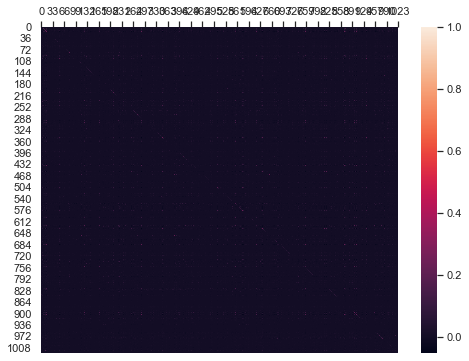

Количество компонент (трость):  1024
[[-0.05950275 -0.02614212 -0.08273083 ...  0.01445903  0.00262484
   0.00353467]
 [ 0.00481585 -0.02007328  0.0001882  ...  0.0217505  -0.0584145
  -0.01572588]
 [ 0.01012645  0.00879499 -0.0081833  ... -0.02522103  0.02979283
   0.01821657]
 ...
 [ 0.00115576 -0.00667854 -0.0031236  ...  0.01721128 -0.02093338
   0.01995707]
 [-0.00463942 -0.00263291  0.0015326  ... -0.04877263 -0.01468568
  -0.06938649]
 [-0.0005775  -0.00956592 -0.00625866 ... -0.0176784   0.01445632
   0.01646899]]
Accuracy: 0.91512


In [165]:
'''
Сломанная трость
'''

X = pd.DataFrame(X)
standardisedX = scale(X)
standardisedX = pd.DataFrame(standardisedX, index=X.index, columns=X.columns)

# не задаем компоненты
pca = my_pca(-1, 2)
# нормализация
X_centered = X - X.mean(axis=0)
pca.fit(X_centered)
Xnew = pca.transform(X_centered)

X_train, X_test, y_train, y_test = train_test_split(Xnew, y, test_size=.3, 
                                                    stratify=y, 
                                                    random_state=42)

clf = DecisionTreeClassifier(max_depth=10, random_state=42)
clf.fit(X_train, y_train)
preds = clf.predict_proba(X_test)
print('Accuracy: {:.5f}'.format(accuracy_score(y_test, 
                                                preds.argmax(axis=1))))

Наилучшая корреляция:
   FirstVariable  SecondVariable  Correlation
0            414             759     0.981486
1            685             871     0.975301
2            260             683     0.972504
3            758             871     0.971219
4            456             819     0.970810
5            288             960     0.970227
6            646             758     0.969676
7            178             405     0.969388
8            116             408     0.967029
9            349             424     0.964966
Наихудшая корреляция:
         FirstVariable  SecondVariable  Correlation
1048566            685             220          0.0
1048567            685             219          0.0
1048568            685             218          0.0
1048569            685             217         -0.0
1048570            685             216          0.0
1048571            685             215         -0.0
1048572            685             214          0.0
1048573            685            

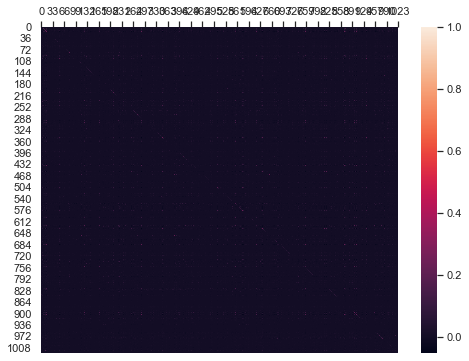

range(0, 1024)


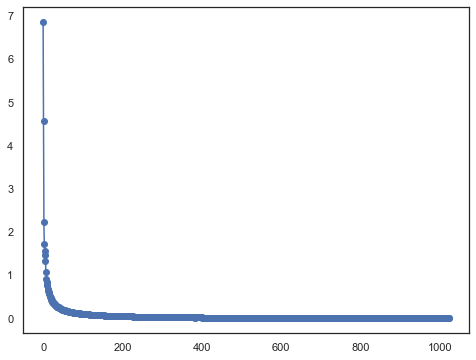

Choose N of components
15
Количество компонент (осыпь):  15
[[-0.05950275 -0.02614212 -0.08273083 ... -0.0107298  -0.01105623
   0.06921862]
 [ 0.00481585 -0.02007328  0.0001882  ...  0.03419011 -0.00833591
   0.02634141]
 [ 0.01012645  0.00879499 -0.0081833  ...  0.02288614  0.02144606
   0.03108689]
 ...
 [ 0.00115576 -0.00667854 -0.0031236  ...  0.00015887 -0.0019464
   0.00386605]
 [-0.00463942 -0.00263291  0.0015326  ...  0.00670999  0.00307327
   0.00683392]
 [-0.0005775  -0.00956592 -0.00625866 ...  0.00654716  0.01335618
  -0.01535751]]
Accuracy: 0.92402


In [166]:
'''
Каменная осыпь
'''

X = pd.DataFrame(X)
standardisedX = scale(X)
standardisedX = pd.DataFrame(standardisedX, index=X.index, columns=X.columns)

# не задаем компоненты
pca = my_pca(-1, 3)
# нормализация
X_centered = X - X.mean(axis=0)
pca.fit(X_centered)
Xnew = pca.transform(X_centered)

X_train, X_test, y_train, y_test = train_test_split(Xnew, y, test_size=.3, 
                                                    stratify=y, 
                                                    random_state=42)

clf = DecisionTreeClassifier(max_depth=6, random_state=42)
clf.fit(X_train, y_train)
preds = clf.predict_proba(X_test)
print('Accuracy: {:.5f}'.format(accuracy_score(y_test, 
                                                preds.argmax(axis=1))))

Наилучшая корреляция:
   FirstVariable  SecondVariable  Correlation
0            414             759     0.981486
1            685             871     0.975301
2            260             683     0.972504
3            758             871     0.971219
4            456             819     0.970810
5            288             960     0.970227
6            646             758     0.969676
7            178             405     0.969388
8            116             408     0.967029
9            349             424     0.964966
Наихудшая корреляция:
         FirstVariable  SecondVariable  Correlation
1048566            685             220          0.0
1048567            685             219          0.0
1048568            685             218          0.0
1048569            685             217         -0.0
1048570            685             216          0.0
1048571            685             215         -0.0
1048572            685             214          0.0
1048573            685            

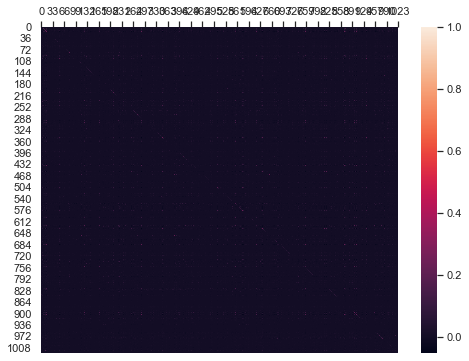

range(0, 1024)


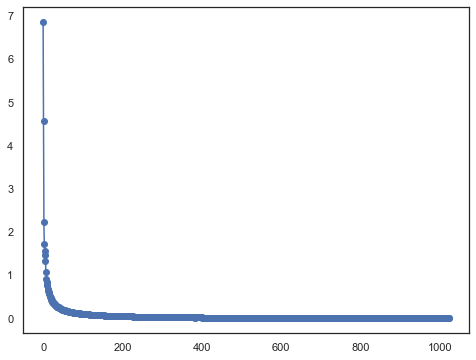

Choose N of components
20
Количество компонент (осыпь):  20
[[-5.95027486e-02 -2.61421171e-02 -8.27308318e-02 ...  2.55515150e-01
  -4.94553292e-02  1.31263575e-02]
 [ 4.81585257e-03 -2.00732800e-02  1.88200543e-04 ... -1.27675329e-02
  -3.44105355e-02 -4.74414956e-03]
 [ 1.01264539e-02  8.79499348e-03 -8.18329894e-03 ...  2.48659745e-02
   1.45981421e-02 -2.31904365e-02]
 ...
 [ 1.15575780e-03 -6.67854499e-03 -3.12359563e-03 ... -2.49898303e-03
   5.45705285e-03 -7.24192940e-03]
 [-4.63941812e-03 -2.63290707e-03  1.53259603e-03 ... -1.61064633e-02
   8.93052804e-03 -4.36022609e-03]
 [-5.77502841e-04 -9.56592022e-03 -6.25866448e-03 ...  8.49081427e-03
   3.45952732e-03  1.15736540e-02]]
Accuracy: 0.91698


In [167]:
'''
Каменная осыпь
'''

X = pd.DataFrame(X)
standardisedX = scale(X)
standardisedX = pd.DataFrame(standardisedX, index=X.index, columns=X.columns)

# не задаем компоненты
pca = my_pca(-1, 3)
# нормализация
X_centered = X - X.mean(axis=0)
pca.fit(X_centered)
Xnew = pca.transform(X_centered)

X_train, X_test, y_train, y_test = train_test_split(Xnew, y, test_size=.3, 
                                                    stratify=y, 
                                                    random_state=42)

clf = DecisionTreeClassifier(max_depth=6, random_state=42)
clf.fit(X_train, y_train)
preds = clf.predict_proba(X_test)
print('Accuracy: {:.5f}'.format(accuracy_score(y_test, 
                                                preds.argmax(axis=1))))

Наилучшая корреляция:
   FirstVariable  SecondVariable  Correlation
0            414             759     0.981486
1            685             871     0.975301
2            260             683     0.972504
3            758             871     0.971219
4            456             819     0.970810
5            288             960     0.970227
6            646             758     0.969676
7            178             405     0.969388
8            116             408     0.967029
9            349             424     0.964966
Наихудшая корреляция:
         FirstVariable  SecondVariable  Correlation
1048566            685             220          0.0
1048567            685             219          0.0
1048568            685             218          0.0
1048569            685             217         -0.0
1048570            685             216          0.0
1048571            685             215         -0.0
1048572            685             214          0.0
1048573            685            

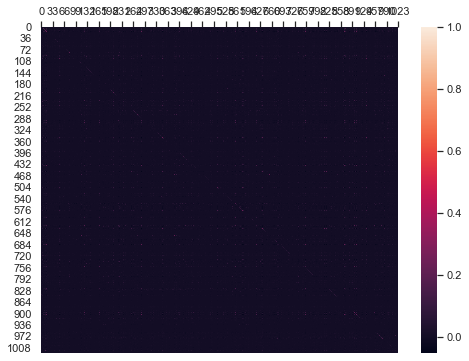

range(0, 1024)


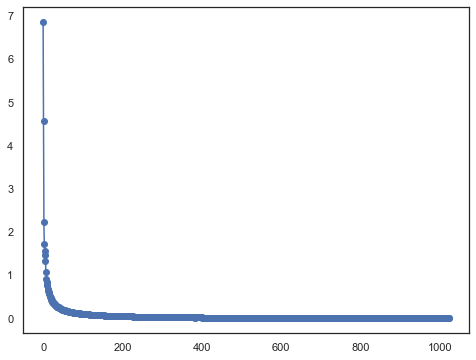

Choose N of components
13
Количество компонент (осыпь):  13
[[-5.95027486e-02 -2.61421171e-02 -8.27308318e-02 ... -3.44162358e-02
   1.74208312e-01 -1.07298035e-02]
 [ 4.81585257e-03 -2.00732800e-02  1.88200543e-04 ... -1.02357442e-02
  -2.08615366e-02  3.41901053e-02]
 [ 1.01264539e-02  8.79499348e-03 -8.18329894e-03 ... -3.30696522e-02
  -4.32320482e-02  2.28861416e-02]
 ...
 [ 1.15575780e-03 -6.67854499e-03 -3.12359563e-03 ... -2.06161558e-03
  -6.91742373e-03  1.58874123e-04]
 [-4.63941812e-03 -2.63290707e-03  1.53259603e-03 ...  1.40440384e-03
  -2.74938588e-04  6.70998918e-03]
 [-5.77502841e-04 -9.56592022e-03 -6.25866448e-03 ... -2.44941423e-02
   1.04223727e-02  6.54716145e-03]]
Accuracy: 0.92254


In [168]:
'''
Каменная осыпь
'''

X = pd.DataFrame(X)
standardisedX = scale(X)
standardisedX = pd.DataFrame(standardisedX, index=X.index, columns=X.columns)

# не задаем компоненты
pca = my_pca(-1, 3)
# нормализация
X_centered = X - X.mean(axis=0)
pca.fit(X_centered)
Xnew = pca.transform(X_centered)

X_train, X_test, y_train, y_test = train_test_split(Xnew, y, test_size=.3, 
                                                    stratify=y, 
                                                    random_state=42)

clf = DecisionTreeClassifier(max_depth=6, random_state=42)
clf.fit(X_train, y_train)
preds = clf.predict_proba(X_test)
print('Accuracy: {:.5f}'.format(accuracy_score(y_test, 
                                                preds.argmax(axis=1))))